In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# 1, データ前処理

In [5]:
# CSV読み込み
df = pd.read_csv("データ_2025年_前処理_因子削除済み.csv", encoding="shift_jis")

# 目的変数を指定（例：出生率）
target_col = "現在の幸福度"
# target_col = "5年後の幸福度"
# target_col = "生活満足度"
# target_col = "町内の幸福度"
# target_col = "周りも楽しい"

# 説明変数と目的変数に分ける
X = df.drop(columns=[ "市区町村", "現在の幸福度", "5年後の幸福度", "生活満足度", "町内の幸福度", "周りも楽しい"])
X_numeric = X.select_dtypes(include=["number"])

y = df[target_col]

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# 2, 最適なfold数と正規化定数の決定

In [11]:
def nested_cv_lasso_summary(
    X_num: pd.DataFrame,
    y: pd.Series,
    k_range=range(2, 11),     # 2..10
    inner_cv=5,
    alphas=None,              # 例: np.logspace(-3, 1, 100)。未指定なら自動生成
    n_alphas=200,
    random_state=0
) -> pd.DataFrame:
    """
    ネストCV: 外側kで分割し、外側train上で標準化→内側CVでα最適化→外側test評価。
    集計（kごとの mean/std の R2, MSE, α, 非ゼロ係数数）を返す。
    """
    rows = []
    for k_outer in k_range:
        outer_kf = KFold(n_splits=k_outer, shuffle=True, random_state=random_state)
        r2_list, mse_list, alpha_list, nnz_list = [], [], [], []

        for tr_idx, te_idx in outer_kf.split(X_num):
            X_tr, X_te = X_num.iloc[tr_idx], X_num.iloc[te_idx]
            y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

            # 外側trainでスケーリングfit → 情報漏洩防止
            scaler = StandardScaler()
            X_tr_sc = scaler.fit_transform(X_tr)
            X_te_sc = scaler.transform(X_te)

            # 内側CVで α 最適化（学習データのみ）
            lcv = LassoCV(
                cv=inner_cv,
                random_state=random_state,
                alphas=alphas,
                n_alphas=(None if alphas is not None else n_alphas)
            )
            lcv.fit(X_tr_sc, y_tr)
            alpha_star = float(lcv.alpha_)

            # 最適αでfit → 外側test評価
            model = Lasso(alpha=alpha_star, random_state=random_state)
            model.fit(X_tr_sc, y_tr)
            y_pred = model.predict(X_te_sc)

            r2_list.append(r2_score(y_te, y_pred))
            mse_list.append(mean_squared_error(y_te, y_pred))
            alpha_list.append(alpha_star)
            nnz_list.append(int(np.sum(model.coef_ != 0)))

        rows.append({
            "k": k_outer,
            "mean_R2": np.mean(r2_list),
            "std_R2": np.std(r2_list, ddof=1),
            "mean_MSE": np.mean(mse_list),
            "std_MSE": np.std(mse_list, ddof=1),
            "alpha_mean": np.mean(alpha_list),
            "alpha_std": np.std(alpha_list, ddof=1),
            "nonzero_coef_mean": np.mean(nnz_list),
            "nonzero_coef_std": np.std(nnz_list, ddof=1),
        })

    return pd.DataFrame(rows).sort_values("k").reset_index(drop=True)


def alpha_mse_curve_for_k(
    X_num: pd.DataFrame,
    y: pd.Series,
    k=5,
    alphas=None,
    n_alphas=200,
    random_state=0
):

    cv = KFold(n_splits=k, shuffle=True, random_state=random_state)

    scaler = StandardScaler()
    X_sc = scaler.fit_transform(X_num)

    # ← ここが重要：kwargsで条件分岐して渡す
    lcv_kwargs = dict(cv=cv, random_state=random_state)
    if alphas is not None:
        lcv_kwargs["alphas"] = alphas
    else:
        lcv_kwargs["n_alphas"] = n_alphas

    lcv = LassoCV(**lcv_kwargs)
    lcv.fit(X_sc, y)

    alphas_out = lcv.alphas_
    mse_path = lcv.mse_path_
    mean_mse = mse_path.mean(axis=1)
    std_mse  = mse_path.std(axis=1)
    best_alpha = float(lcv.alpha_)

    return {
        "alphas": alphas_out,
        "mse_path": mse_path,
        "mean_mse": mean_mse,
        "std_mse": std_mse,
        "best_alpha": best_alpha
    }

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019808394719351696, tolerance: 0.0014066934314025427
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00319272663877479, tolerance: 0.0014066934314025427
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003974514425753473, tolerance: 0.0014066934314025427
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coor

===== R^2 =====


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011056201983433489, tolerance: 0.002403561113308247
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009053781343777878, tolerance: 0.002403561113308247
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011065478589774358, tolerance: 0.002403561113308247
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordin

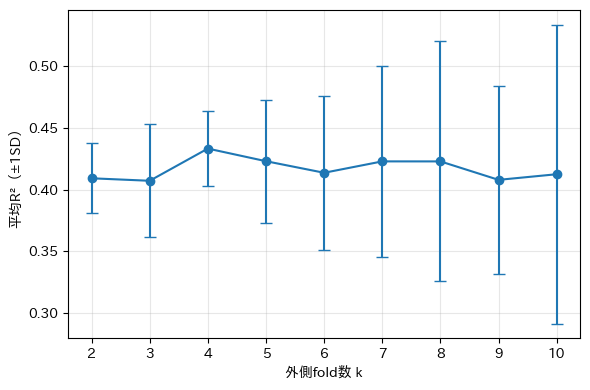

===== MSE =====


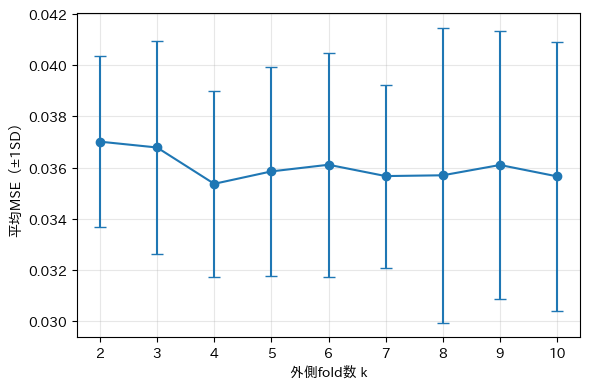

In [13]:
cv_summary = nested_cv_lasso_summary(X_numeric, y, k_range=range(2, 11), inner_cv=5, random_state=0)

print("===== R^2 =====") 
plt.figure(figsize=(6,4))
plt.errorbar(
    cv_summary["k"],          
    cv_summary["mean_R2"],       
    yerr=cv_summary["std_R2"],   
    marker="o", capsize=4
)
plt.xlabel("fold数 k")
plt.ylabel("平均R²（±1SD）")
plt.tight_layout()
plt.show()

print("===== MSE =====")
plt.figure(figsize=(6,4))
plt.errorbar(
    cv_summary["k"],
    cv_summary["mean_MSE"],
    yerr=cv_summary["std_MSE"],
    marker="o", capsize=4
)
plt.xlabel("fold数 k")
plt.ylabel("平均MSE（±1SD）")
plt.tight_layout()
plt.show()

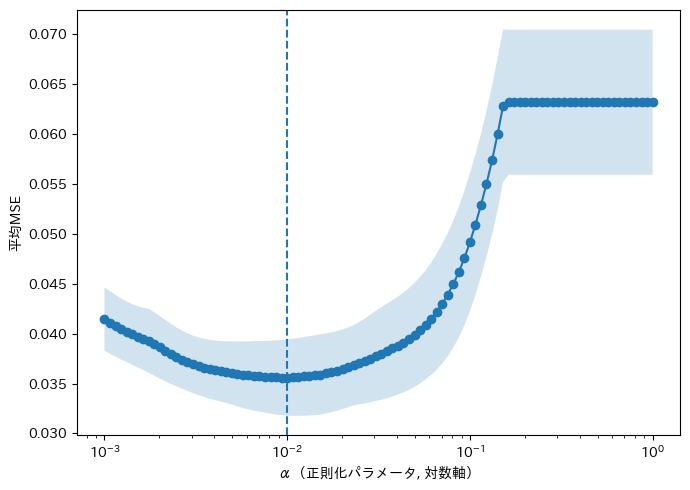

best alpha: 0.01


In [14]:
payload = alpha_mse_curve_for_k(X_numeric, y, k=5, alphas=np.logspace(-3, 0, 100), random_state=0)

plt.figure(figsize=(7,5))
plt.semilogx(payload["alphas"], payload["mean_mse"], marker="o")
plt.fill_between(payload["alphas"], payload["mean_mse"]-payload["std_mse"], payload["mean_mse"]+payload["std_mse"], alpha=0.2)
plt.axvline(payload["best_alpha"], linestyle="--")
plt.xlabel("α（正則化パラメータ, 対数軸）"); plt.ylabel("平均MSE")
plt.tight_layout(); plt.show()
print("best alpha:", payload["best_alpha"])